In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
import matplotlib.pyplot as plt
import datetime

# check available GPU

In [4]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# custom layers

In [6]:
class IdentityBlock(tf.keras.Model):
    
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
        
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.add([x, input_tensor])
        x = self.act(x)
        
        return x

In [7]:
class ResNet(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D()
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
        
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)
        
        x = self.id1a(x)
        x = self.id1b(x)
        
        x = self.global_pool(x)
        return self.classifier(x)

# GPU setup

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [9]:
%load_ext tensorboard
# Clear any logs from previous runs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
resnet = ResNet(10)
resnet.build((None, 32, 32, 1))
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
             metrics=['acc'])
resnet.summary()

# load data
(train_img,train_lable),(test_img,test_lable)=tf.keras.datasets.mnist.load_data()
train_img= train_img/ 255
test_img= test_img / 255
train_img = np.expand_dims(train_img, 3)
test_img = np.expand_dims(test_img, 3)

# train
history = resnet.fit(train_img,train_lable,epochs=5, batch_size=32, shuffle=True, callbacks=[tensorboard_callback])

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            multiple                  3200      
_________________________________________________________________
batch_normalization_5 (Batch multiple                  256       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
identity_block_2 (IdentityBl multiple                  74368     
_________________________________________________________________
identity_block_3 (IdentityBl multiple                  74368     
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0 

# visualization

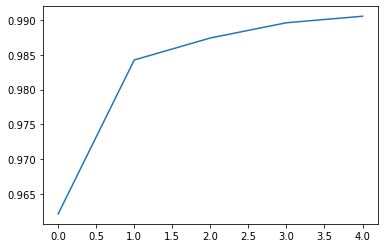

In [12]:
plt.plot(history.history['acc'])

In [13]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10708), started 10:21:55 ago. (Use '!kill 10708' to kill it.)